# TensorFlow Implementaton of Laplace Approximation for GP Hyperparameters (w/ Internal Newton Optimiser)
This is an example python script to illustrate LA GP fitting with TensorFlow

## Step 1: Read in summarised TRaC data with matched covariates and build as TensorFlow constants 

- Age restricted to 1-50 y/o (to limit impact of maternal anti-bodies and limit look-back time)

- Sites snapped to land-sea mask boundary and standardised covariates extracted

- Area including Port-au-Prince and surrounds excluded (to limit impact of migration) 

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
from scipy.io import mmread
import osgeo.gdal as gdal
import os
import matplotlib.pyplot as plt

tracdata = pd.read_csv('../trac_data/summary_TRaC_data_with_covariates.csv')

village_lats = tracdata.groupby(['Cluster_Num'])['Latitude'].mean().values
village_longs = tracdata.groupby(['Cluster_Num'])['Longitude'].mean().values

meanMSP = np.log(tracdata.groupby(['Cluster_Num'])['MSP'].mean().values) # In this contrived example we will fit a GP regression for the mean MSP in each village
Nvillages = meanMSP.size
meanMSP = tf.constant(meanMSP, dtype='float32')
covariates = tracdata.groupby(['Cluster_Num'])['covariate_accessibility','covariate_AI','covariate_distTowater','covariate_elevation','covariate_forest','covariate_grass','covariate_urbanbarren','covariate_woodysavanna','covariate_OSM','covariate_PET','covariate_slope','covariate_TWI'].mean().values
Ncovariates = covariates.shape[1]
covariates = tf.constant(covariates, dtype='float32')

## Step 2: Read in INLA projection and SPDE precision matrices

- These are pre-cooked in the R preprocessing script

In [2]:
Amatrix = mmread('data/A_matrix.mtx')
Nmesh = Amatrix.shape[1]
M0 = mmread('data/M0_matrix.mtx')
M1 = mmread('data/M1_matrix.mtx')
M2 = mmread('data/M2_matrix.mtx')
Amatrix = tf.constant(Amatrix.toarray(), dtype='float32') # Not sure if it's worth figuring out how to use SparseTensors
M0 = tf.constant(M0.toarray(), dtype='float32')
M1 = tf.constant(M1.toarray(), dtype='float32')
M2 = tf.constant(M2.toarray(), dtype='float32')

## Step 3: Priors and transformations for GMRF model

- Precision matrix (Q) constructed as per Eqn 10 of Lingren et al.: https://rss.onlinelibrary.wiley.com/doi/full/10.1111/j.1467-9868.2011.00777.x

In [3]:
log_kappa = tf.Variable(1.0, dtype ='float32')
prior_log_kappa = tfp.distributions.Normal(loc = 0.0, scale = 1.0)

log_tau = tf.Variable(-3.0, dtype = 'float32')
prior_log_tau = tfp.distributions.Normal(loc = 0.0, scale = 1.0)

log_field = tf.constant(np.zeros(Nmesh), dtype='float32')
#log_field = tf.Variable(np.zeros(Nmesh), dtype='float32')
spde_prec = (tf.exp(log_kappa*4.0)*M0 + tf.constant(2.0, dtype ='float32')*tf.exp(log_kappa*2.0)*M1 + M2)*tf.exp(log_tau*tf.constant(2.0,dtype = 'float32'))
spde_cov = tf.matrix_inverse(spde_prec)
prior_log_field = tfp.distributions.MultivariateNormalFullCovariance(loc = tf.constant(np.zeros(Nmesh), dtype='float32'), covariance_matrix = spde_cov)

slopes = tf.Variable(np.zeros(Ncovariates), dtype='float32')
prior_slopes = tfp.distributions.Normal(loc = 0.0, scale = 1.0)

intercept = tf.Variable(0.0, dtype='float32')

prior_intercept = tfp.distributions.Normal(loc = 0.0, scale = 5.0)

## Step 4: Set up empircal Bayes GP hyperparameter search in TensorFlow

In [4]:
def inner_vector_update(log_field, iter_diff, log_laplace_approximation, output_collections=(), name=None):
    
    log_field = tf.convert_to_tensor(log_field)
    
    linear_predictor = tf.squeeze(tf.matmul(Amatrix,tf.expand_dims(log_field,1))) + intercept + tf.squeeze(tf.matmul(covariates,tf.expand_dims(slopes,1)))
        
    log_prior = prior_log_kappa.log_prob(log_kappa) + prior_log_tau.log_prob(log_tau) + prior_log_field.log_prob(log_field) + tf.reduce_sum(prior_slopes.log_prob(slopes)) + prior_intercept.log_prob(intercept)
    likelihood_data = tfp.distributions.Normal(loc = linear_predictor, scale = 10.0)
    log_likelihood = tf.reduce_sum(likelihood_data.log_prob(meanMSP))
    negative_log_posterior_prob = -(log_likelihood + log_prior)

    new_log_field = log_field - tf.constant(0.5, dtype = 'float32')*tf.squeeze(tf.matmul(tf.squeeze(tf.matrix_inverse(tf.hessians(negative_log_posterior_prob,log_field))),tf.expand_dims(tf.squeeze(tf.gradients(negative_log_posterior_prob,log_field)),1)))
    new_iter_diff = tf.reduce_sum(tf.abs(log_field-new_log_field))
  
    new_log_laplace_approximation = tf.constant(Nmesh*0.9189385, dtype = 'float32') - tf.constant(0.5, dtype = 'float32')*tf.linalg.logdet(tf.squeeze(tf.hessians(negative_log_posterior_prob,log_field))) - negative_log_posterior_prob
        
    return [new_log_field, new_iter_diff, new_log_laplace_approximation]
    
def running_condition(log_field,iter_diff,log_laplace_approximation, output_collections=(), name=None):
    return tf.greater(iter_diff,tf.constant(0.001, dtype = 'float32')) 

log_laplace_approximation = tf.constant(0.0, dtype = 'float32')
iter_diff = tf.constant(100000000000000000000.0, dtype = 'float32')

iteration_outputs = tf.while_loop(running_condition,inner_vector_update,[log_field,iter_diff,log_laplace_approximation])

## Step 5: Run optimisation to find empirical Bayes hyperparameters

- Uses the AdaGrad algorithm: probably we want to switch to our own Bayesian optimisation later(?)

In [5]:
log_laplace_approx_at_conditional_mode = iteration_outputs[2]
log_field_at_conditional_mode = iteration_outputs[0]

optimiser = tf.train.AdagradOptimizer(0.05) # Behaviour sensitive to this training rate!
train = optimiser.minimize(-log_laplace_approx_at_conditional_mode, var_list = [log_kappa, log_tau, slopes, intercept])

sess = tf.Session()
sess.run(tf.global_variables_initializer())

sess.run(train)
sess.run(train)

log_kappa_diff = 1000.0 # This is not a sophisticated stopping criterion!
old_log_kappa = sess.run(log_kappa)
while (log_kappa_diff > 0.01):
    sess.run(train)
    log_kappa_diff = np.abs(sess.run(log_kappa)-old_log_kappa)
    old_log_kappa = sess.run(log_kappa)
    print(log_kappa_diff)

0.024708986
0.021260679
0.018940747
0.017231584
0.015901804
0.0148204565
0.013919711
0.013160288
0.012508452
0.011933506
0.011424959
0.0109705925
0.010561109
0.010189533
0.009852707


## Step 6: Plot posterior mode field at empirical Bayes hyperparmeters

- Requires GDAL for raster io: https://www.lfd.uci.edu/~gohlke/pythonlibs/#gdal

In [6]:
log_field = sess.run(log_field_at_conditional_mode)
slopes = sess.run(slopes)
intercept = sess.run(intercept)

Afullmatrix = mmread('data/Afull_matrix.mtx')
Afullmatrix = Afullmatrix.toarray()
covariatesfull = pd.read_csv('data/fullcovariates.csv').values[:,1:13]
linear_predictor = np.matmul(Afullmatrix,log_field) + np.matmul(covariatesfull,slopes) + intercept

In [7]:
ds = gdal.Open('data/covariates_AI.tif')
covariate = ds.GetRasterBand(1)
nodata = covariate.GetNoDataValue()
referenceimage = covariate.ReadAsArray()
referenceimage = np.ma.masked_less(referenceimage,-3)

valid_pixels = referenceimage.mask==0
valid_pixels_indices = np.nonzero(np.ndarray.flatten(valid_pixels)) # row-major flattening
n_valid_pixels = np.sum(valid_pixels)

xoff, a, b, yoff, d, e = ds.GetGeoTransform() # NOTE: this seems like an incredibly tedious way to deal with raster geometries, but I could not find anything more sensible online (??)
x0, dx, dxdy, y0, dydx, dy = ds.GetGeoTransform()
nrows, ncols = referenceimage.shape
lonarray = np.linspace(x0+dx/2, x0+dx/2+dx*ncols, ncols)
latarray = np.linspace(y0+dy/2, y0+dy/2+dy*nrows, nrows)
pixel_longs, pixel_lats = np.meshgrid(lonarray, latarray)

#pixel_longs = a * np.transpose(np.reshape(np.repeat(np.arange(referenceimage.shape[1]),referenceimage.shape[0]),(referenceimage.shape[1],referenceimage.shape[0]))) + b * np.reshape(np.repeat(np.arange(referenceimage.shape[0]),referenceimage.shape[1]),referenceimage.shape) + xoff
#pixel_lats = d * np.transpose(np.reshape(np.repeat(np.arange(referenceimage.shape[1]),referenceimage.shape[0]),(referenceimage.shape[1],referenceimage.shape[0]))) + e * np.reshape(np.repeat(np.arange(referenceimage.shape[0]),referenceimage.shape[1]),referenceimage.shape) + yoff

referenceimage.put(np.where(np.ndarray.flatten(referenceimage.mask)==0),linear_predictor)

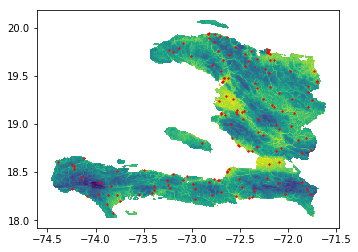

In [8]:
plt.scatter(village_longs, village_lats, c='red', s = 1) # check image coordinate transforms by comparing raster plot against observation locations 
#imgplot = plt.imshow(referenceimage,extent=[np.min(pixel_longs[valid_pixels]),np.max(pixel_longs[valid_pixels]),np.min(pixel_lats[valid_pixels]),np.max(pixel_lats[valid_pixels])])
imgplot = plt.imshow(referenceimage,extent=[np.min(pixel_longs),np.max(pixel_longs),np.min(pixel_lats),np.max(pixel_lats)])
#plt.scatter(pixel_longs, pixel_lats, c='red', s = 0.001) # check image coordinate transforms by comparing raster plot against observation locations 
plt.scatter(village_longs, village_lats, c='red', s = 1) # check image coordinate transforms by comparing raster plot against observation locations 
plt.xlim(np.min(pixel_longs),np.max(pixel_longs))
plt.ylim(np.min(pixel_lats),np.max(pixel_lats))
plt.show() # NOTE: seems to only display figure if I run this code a second time around: why?

In [9]:
sess.run(log_field_at_conditional_mode)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.